### Mathias H. Morgan


In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [243]:
stockVolDf = pd.read_csv('A1_stock_volatility_labeled.csv')

# Phase 1: Exploration

In [244]:
stockVolDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13486 entries, 0 to 13485
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       13486 non-null  object 
 1   Open                       13486 non-null  float64
 2   Close                      13486 non-null  float64
 3   High                       13486 non-null  float64
 4   Low                        13486 non-null  float64
 5   Volume                     13486 non-null  int64  
 6   Amount                     13486 non-null  float64
 7   Avg_Price                  13486 non-null  float64
 8   Return                     13486 non-null  float64
 9   Volatility                 13486 non-null  float64
 10  Revenue                    13486 non-null  float64
 11  Net Income                 13486 non-null  float64
 12  Gross Profit               13486 non-null  float64
 13  EPS                        13486 non-null  flo

In [245]:
print("--- Dataset Overview ---")
stockVolDfCoutnt = stockVolDf.shape[0]
print(f"Number of training data rows: {stockVolDfCoutnt:,}")

--- Dataset Overview ---
Number of training data rows: 13,486


In [246]:
print("--- Checking for missing missing values ---\n")
print(f"Missing labels in stockVolDf: \n{stockVolDf.isna().sum()}")

--- Checking for missing missing values ---

Missing labels in stockVolDf: 
Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64


In [247]:
print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrain = stockVolDf.eq('').sum()
print(f"Number of empty/whitespace-only reviews: {emptyCountTrain}...")


--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64...


In [248]:
print("\n--- Checking for duplicate reviews ---")
duplicateRowCount = stockVolDf.duplicated().sum()
print(f"Number of duplicate reviews in test data: {duplicateRowCount}...")


--- Checking for duplicate reviews ---
Number of duplicate reviews in test data: 0...


In [249]:
stockVolDf['Date'] = pd.to_datetime(stockVolDf['Date'])

Features

In [250]:
stockVolDf.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price',
       'Return', 'Volatility', 'Revenue', 'Net Income', 'Gross Profit', 'EPS',
       'Total Assets', 'Total Liabilities', 'Total Equity',
       'Cash and Cash Equivalents', 'Operating Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow', 'Stock'],
      dtype='object')

Transform Target

In [251]:
# Apply log transformation to Volatility
stockVolDf['Volatility_Log'] = np.log(stockVolDf['Volatility'] + 1)

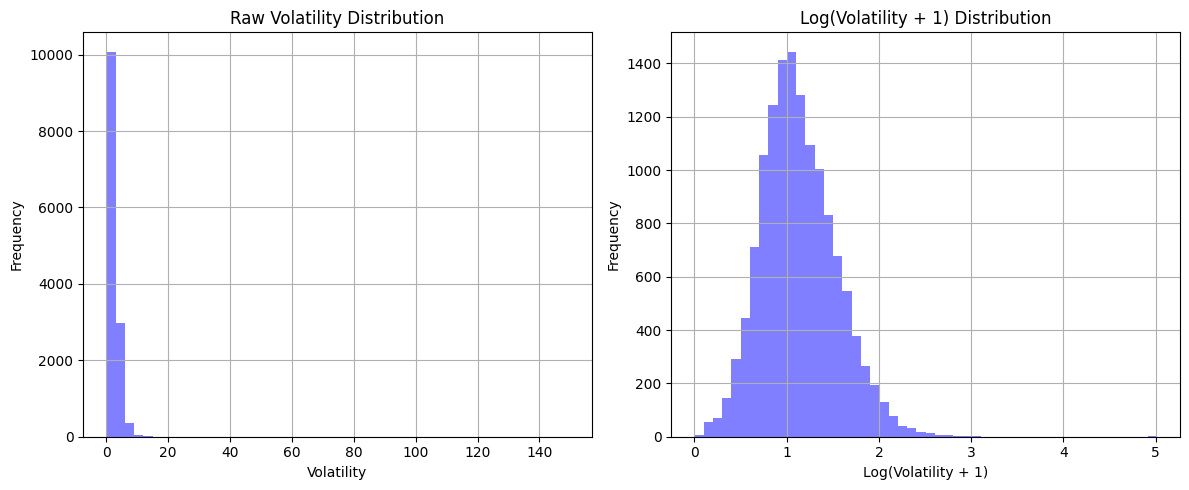

In [252]:
# Visualize distribution before and after
plt.figure(figsize=(12, 5))

# Create pre transformation histogram
plt.subplot(1, 2, 1)
stockVolDf['Volatility'].hist(bins=50, alpha=0.5, color='blue')
plt.title('Raw Volatility Distribution')
plt.xlabel('Volatility')
plt.ylabel('Frequency')

# Create post transformation histogram
plt.subplot(1, 2, 2)
stockVolDf['Volatility_Log'].hist(bins=50, alpha=0.5, color='blue')
plt.title('Log(Volatility + 1) Distribution')
plt.xlabel('Log(Volatility + 1)')
plt.ylabel('Frequency')

# Display plots
plt.tight_layout()
plt.show()


In [253]:
# Extract month
stockVolDf['month'] = stockVolDf['Date'].dt.month

# Cyclical encoding
stockVolDf['month_sin'] = np.sin(2 * np.pi * stockVolDf['month'] / 12)
stockVolDf['month_cos'] = np.cos(2 * np.pi * stockVolDf['month'] / 12)

# Optional: Drop raw month
stockVolDf = stockVolDf.drop('month', axis=1)

In [254]:
# 3 lagged features for log volatility (fixed from 'target_log_vol' to 'Volatility_Log')
for lag in [1, 2, 3]:
    stockVolDf[f'vol_lag{lag}'] = stockVolDf.groupby('Stock')['Volatility_Log'].shift(lag)

In [255]:
# Features to lag from trading (monthly): Volume, Amount, Return, Volatility_Log
trading_to_lag = ['Volume', 'Amount', 'Return', 'Volatility_Log']
for col in trading_to_lag:
    for lag in [1, 2, 3]:  # 1-3 lags for monthly features
        stockVolDf[f'{col}_lag{lag}'] = stockVolDf.groupby('Stock')[col].shift(lag)

In [256]:
# Features to lag from financial (quarterly): All of them
financial_to_lag = [
    'Revenue', 'Net Income', 'Gross Profit', 'EPS',
    'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents',
    'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow']

for col in financial_to_lag:
    stockVolDf[f'{col}_lag1'] = stockVolDf.groupby('Stock')[col].shift(1)  # 1 lag for quarterly (updates every 3 months)

In [257]:
# Drop rows with NaN in any lagged column (first 3 rows per stock typically)
lag_cols = [f'vol_lag{lag}' for lag in [1,2,3]] + \
           [f'{col}_lag{lag}' for col in trading_to_lag for lag in [1,2,3]] + \
           [f'{col}_lag1' for col in financial_to_lag]
stockVolDf = stockVolDf.dropna(subset=lag_cols).reset_index(drop=True)
print(lag_cols)

['vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']


In [ ]:
# Standard scaling of numeric features
numeric_cols = stockVolDf.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
stockVolDf[numeric_cols] = scaler.fit_transform(stockVolDf[numeric_cols])
print(f"Scaled {len(numeric_cols)} numeric features: {numeric_cols}")

Scaled 49 numeric features: ['Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price', 'Return', 'Volatility', 'Revenue', 'Net Income', 'Gross Profit', 'EPS', 'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents', 'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow', 'Volatility_Log', 'month_sin', 'month_cos', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']


In [260]:
stockVolDf.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price',
       'Return', 'Volatility', 'Revenue', 'Net Income', 'Gross Profit', 'EPS',
       'Total Assets', 'Total Liabilities', 'Total Equity',
       'Cash and Cash Equivalents', 'Operating Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow', 'Stock', 'Volatility_Log',
       'month_sin', 'month_cos', 'vol_lag1', 'vol_lag2', 'vol_lag3',
       'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1',
       'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2',
       'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2',
       'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1',
       'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1',
       'Total Liabilities_lag1', 'Total Equity_lag1',
       'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1',
       'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1'],
      dtype='object')

In [261]:
stockVolDf.to_csv('A1_stock_volatility_feature_engineered.csv', index=False)

# References

https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0